## Wikipedia Articles Clustering (NLP)
`EDA (Exploratory Data Analysis)`

**Abstract**: We load data from The 20 newsgroups text dataset, which comprises around 18,000 newsgroups posts on 20 topics. For illustrative purposes and to reduce the computational cost, we select a subset of 4 topics only accounting for around 3,400 documents. See the example Classification of text documents using sparse features to gain intuition on the overlap of such topics. <br>
**Source**: https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset

In [9]:
# Loading libraries
import pandas as pd
import numpy as np
import nltk
from sklearn import metrics
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Initial setting
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_colwidth = 100
pd.set_option('display.max_columns', None)

In [12]:
# Loading the Data
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space"
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In [13]:
# Building a DataFrame structure
df = pd.DataFrame([dataset.data, dataset.target.tolist()]).T
df.columns = ['text', 'target']

# Gathering the target names indexes
targets = pd.DataFrame(dataset.target_names)
targets.columns=['title']

# Joining all the data into a single dataset
out = pd.merge(df, targets, left_on='target', right_index=True)
out.head()

,text,target,title
0,My point is that you set up your views as the only way to believe. Saying \nthat all eveil in t...,0,alt.atheism
9,"\n]The ""corrupted over and over"" theory is pretty weak. Comparison of the\n]current hebrew tex...",0,alt.atheism
14,"\n\nBut, you wouldn't know what red *was*, and you certainly couldn't judge\nit subjectively. A...",0,alt.atheism
26,"\n\nWell I agree with you in the sense that they have no ""moral"" right to inflict\nthese rules, ...",0,alt.atheism
27,"\n\nSpecifically, which changes are you talking about? Are you arguing\nthat the motto is inter...",0,alt.atheism


### Class to apply the model

In [70]:
class text_cluster_model():

    def __init__(self, dataset: list, plot_results: bool = False) -> None:
        self.dataset = dataset
        self.plot_results = plot_results
        self.vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words="english")

    @classmethod
    def __plot_lsa__(self, svd) -> plt.figure:
        features  = range(1, len(svd.components_))

        fig = plt.figure(figsize=(8, 6))
        plt.bar(features, svd.explained_variance_ratio_[1:])
        plt.xlabel('SVD Features')
        plt.ylabel('Variances')
        plt.title('Variance per SVD Feature')

        return fig

    @classmethod
    def __plot_opt_components_number__(self, x_tfidf: pd.DataFrame, svd) -> plt.figure:
        
        fig = plt.figure(figsize=(8, 6))

        # Alternative way to upgrade the procedure performed above
        # * Verificar o x_tfidf está correto, montar um if futuramente.
        plt.plot(range(0, x_tfidf.shape[0]), svd.explained_variance_ratio_.cumsum()*100, 
                        marker= 'o', linestyle = '--', color = 'b')

        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Sum of Variance (%)')
        plt.title('Optimized number of components SVD')
        # plt.xticks(np.arange(0, max(variance['index']), step=1), rotation = 90) #change from 0-based array index to 1-based human-readable label

        plt.axhline(y= 80, color='r', linestyle='-')
        plt.text(30, 82, '80% cut-off threshold', color = 'red', fontsize=10)

        return fig
    
    @classmethod
    def __plot_elbow__(self, inertias: list, ks: range)-> plt.figure:
        # Plot ks vs inertias
        fig = plt.figure(figsize=(8, 6))
        plt.plot(ks, inertias, '-o');
        plt.xlabel('Número de Clusters')
        plt.ylabel('Distorção/Inércia')
        plt.title('Método de Elbow')
        plt.xticks(ks)
        
        return fig

    def extract_features(self) -> pd.DataFrame:
        vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words="english")
        t0 = time()
        x_tfidf = vectorizer.fit_transform(self.dataset)

        # ToDo: Passar para logging.info
        print(f"vectorization done in {time() - t0:.3f} s")
        print(f"n_samples: {x_tfidf.shape[0]}, n_features: {x_tfidf.shape[1]}")
        print(f"We find that around {round(x_tfidf.nnz / np.prod(x_tfidf.shape)*100, 2):.2f}% of the entries of the X_tfidf matrix are non-zero")

        return x_tfidf, vectorizer

    def reduce_dimensions(self, x_tfidf: pd.DataFrame) -> pd.DataFrame:
        # Instance of SVD
        svd = TruncatedSVD(x_tfidf.shape[1] - 1)

        # Making a pipeline for applying LSA (dimensionality reduction), and normalizing the data
        pipeline = make_pipeline(svd, Normalizer(copy=False))
        
        # Pipeline Fit
        pipeline.fit(x_tfidf)

        if self.plot_results:
            # LSA plot - Explained Variance Ratio
            self.__plot_lsa__(svd).show()
            
            # Plotting the optimize number of components SVD
            self.__plot_opt_components_number__(x_tfidf, svd)
            
        tsvd_var_ratios = svd.explained_variance_ratio_

        return x_tfidf, tsvd_var_ratios
    
    def optimize_components_number(self, x_tfidf: list, var_ratio: float, goal_var: float):
        # Set initial number of features and variance explained so far
        total_variance, opt_n_components = 0.0, 0
        
        for explained_variance in var_ratio:
            # Add the explained variance to the total
            total_variance += explained_variance
            # Add one to the number of components
            opt_n_components += 1
            
            # If we reach our goal level of explained variance
            if total_variance >= goal_var:
                break
        
        print(f'Optimized number of components: {opt_n_components}')

        # Use the number of components
        lsa = make_pipeline(TruncatedSVD(n_components= opt_n_components), Normalizer(copy=False))
        t0 = time()
        x_lsa = lsa.fit_transform(x_tfidf)
        explained_variance = lsa[0].explained_variance_ratio_.sum()

        print(f"LSA done in {time() - t0:.3f} s")
        print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")
        return x_lsa, lsa
    
    def optimize_clusters_number(self, x_lsa: list):
        # Calculate the perfomance measures
        # perform Elbow Method
        ks = range(2, 16)
        inertias = []
        n_cluster = []
        ss_indexes = []

        for k in ks:
            # Criação da instância do K-Means com k clusters: model
            model = KMeans(n_clusters = k, random_state= 12345)
            
            # Fit do modelo ao dataset
            model.fit(x_lsa)

            # Inertia and labels append
            inertias.append(model.inertia_)
            labels = model.labels_
            # print(f"Tamanho do labels:{len(labels)}, values:{np.unique(labels)}")
            # print(f"Tamanho das features:{len(x_lsa)}")

            # try:
              # Silhouette Score
            ss_index = metrics.silhouette_score(x_lsa, labels)

            # except ValueError: 
            #   print("Problema dos labels")
            n_cluster.append(k)
            ss_indexes.append(ss_index)
        

        df_ss = pd.DataFrame({'n_cluster': n_cluster, 'ss_indexes': ss_indexes})

        # Perform local maxima method
        max_ind = argrelextrema(df_ss['ss_indexes'].to_numpy(), np.greater)
        n_clusters = df_ss['n_cluster'].iloc[max_ind].max()

        if np.isnan(n_clusters):
            n_clusters = df_ss.loc[df_ss['ss_indexes'] == df_ss['ss_indexes'].max()]['n_cluster'].to_list()[0]

        if self.plot_results:            
            # Plot elbow results
            # ? Transform this into a function?
            plt.figure(figsize=(8, 6))
            plt.plot(ks, inertias, '-o')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Distortion/InertiaDistorção/Inércia')
            plt.title('Elbow Method')
            plt.xticks(ks)
            plt.show()

            # Plotting local Maxima method
            plt.figure(figsize=(10, 6))
            plt.plot(df_ss['n_cluster'], df_ss['ss_indexes'], '-')
            plt.xlabel('n_cluster')
            plt.ylabel('ss_indexes')
            plt.title('Local Maxima')
            plt.show()

        else:
            #ToDo: Warn the user that this method needs to set self.plot equals True
            #ToDo: return the diagnosis analysis into a DataFrame
            print('')
        #ToDo: Trocar n_clusters por n_cluster
        return n_clusters
            
    def cluster_texts(self, x_lsa, n_clusters, lsa, vectorizer):
        # K-Means instance
        kmeans = KMeans(n_clusters= n_clusters, random_state= 12345)

        # Model Fit
        kmeans.fit(x_lsa)

        original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
        terms = vectorizer.get_feature_names_out()

        for i in range(true_k):
            print(f"Cluster {i}: ", end="")
            for ind in order_centroids[i, :10]:
                print(f"{terms[ind]} ", end="")
          

modeller = text_cluster_model(dataset.data, True)

In [68]:
features, vectorizer = modeller.extract_features()

vectorization done in 0.505 s
n_samples: 3387, n_features: 7929
We find that around 0.69% of the entries of the X_tfidf matrix are non-zero


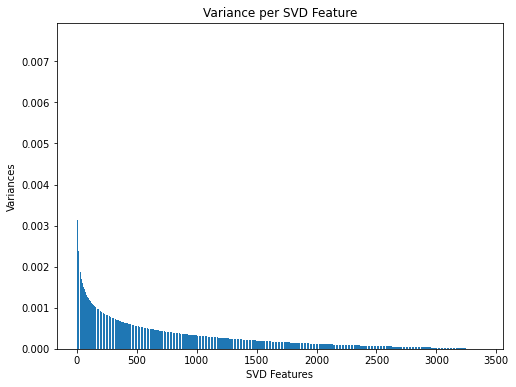

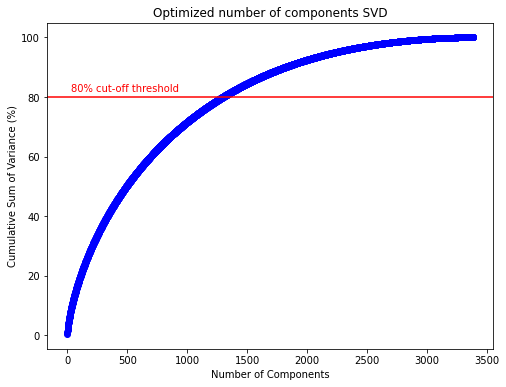

In [19]:
reduced_features, tsvd_var_ratios = modeller.reduce_dimensions(features)

In [62]:
x_lsa, lsa = modeller.optimize_components_number(reduced_features, tsvd_var_ratios, .8)

Optimized number of components: 1298
LSA done in 20.121 s
Explained variance of the SVD step: 79.7%


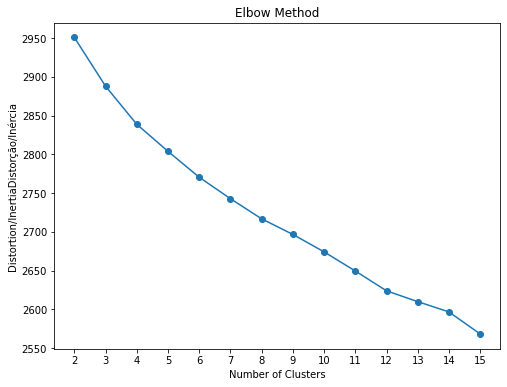

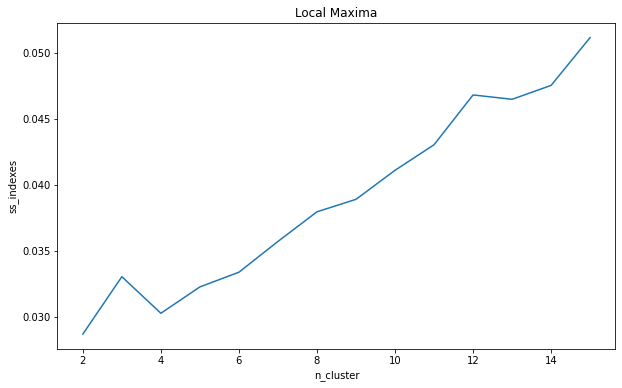

In [42]:
n_cluster = modeller.optimize_clusters_number(x_lsa)

In [49]:
x_lsa[0]

array([ 3.90199503e-01, -1.76174463e-01, -7.39256367e-02, -9.48350858e-02,
        3.03746231e-02, -2.45208346e-02,  2.47428438e-02,  4.93759439e-02,
        1.10664094e-01,  2.25187055e-01, -2.84572704e-01,  1.64530380e-02,
       -3.35978548e-04,  1.43693143e-02, -2.99558003e-02,  4.30300082e-02,
       -3.49783574e-02, -1.38762260e-02,  2.14818755e-02, -5.00336476e-02,
       -1.02107414e-01,  7.13030523e-02, -3.63285486e-02, -1.08374590e-01,
       -1.52628675e-01, -1.16647718e-01,  9.21815317e-02, -9.74009375e-02,
       -1.20399472e-01, -1.17414311e-01,  6.72771417e-02, -8.24570864e-04,
       -4.53235715e-02, -4.05301238e-02,  7.12595803e-02, -3.94177251e-02,
        3.58180136e-02,  1.02843699e-02, -1.91463887e-01, -3.68418680e-02,
        1.68805217e-01, -1.00596229e-01,  1.50831883e-01,  7.34973081e-02,
       -4.31293759e-03, -1.35178523e-01,  1.10919517e-01, -1.76486735e-01,
        1.26076695e-02,  5.92609036e-02, -7.51256401e-02,  9.19325041e-02,
       -8.12208063e-02, -

In [71]:
modeller.cluster_texts(x_lsa, 4, lsa, vectorizer)

Cluster 0: just don think like know people time does did good Cluster 1: graphics thanks image file files know format program help looking Cluster 2: god jesus people believe bible don christian say think religion Cluster 3: space nasa shuttle launch orbit moon mission earth like cost 